7/21/2021

Need to slightly change the way we're getting the "median" CIV distance in each Gamma bin for the first step.

Take equally populated bins in Gamma.

Clean up notebook 4 a bit?

In [1]:
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from astropy.stats import sigma_clip
import matplotlib.mlab as mlab
import sys
sys.path.append("/Users/Trevor1/Desktop/git/CIV_Distance/")
from CIVfunctions import project,CIV_distance

In [2]:
#Default MPL colorcycle
mplcol = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None, label=""):
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label=label) #label only once

In [4]:
#Load in all Xray data
df = Table.read('AllXRayData.071221.fits', format='fits')
dat = df.to_pandas()
dat.head()

SDSS  LOGEDD_RATIO    Gamma  f2keV_ergs      L2500  \
0  b'SDSSJ123003.80+162308.2'         -0.76  1.85810  -31.759840  31.096001   
1  b'150313.62+575151.5     '         -0.42  2.20000  -30.648514  31.443727   
2  b'SDSSJ092513.03+363748.5'           NaN  2.13456  -32.024640  30.580400   
3  b'SDSSJ135320.48+400809.8'         -0.66  2.89310  -31.597590  30.796700   
4  b'103151.76-013557.2     '           NaN  1.60000  -31.154761  30.838674   

   Alpha_ox  Delta_Alpha_ox  New_Delta_Alpha_ox    Delg-i  Timlin_CIV_EQW  \
0 -1.617769       -0.002665           -0.039064  0.116000             NaN   
1 -1.622615        0.061687            0.022610 -0.071669             NaN   
2 -1.456527        0.055972            0.023543  0.042000             NaN   
3 -1.584457       -0.028914           -0.063009 -0.095000             NaN   
4 -1.499198        0.064698            0.030281 -0.141138             NaN   

   ...  Old_redshift  Redshifts  HeII_EQW  LOGBH  Data_source  Clean  \
0  ...           NaN    2.37464  0.393129   9.72            4  False   
1  ...      1.721368        NaN       NaN   9.59            1  False   
2  ...           NaN    2.77289  2.818198    NaN            4  False   
3  ...           NaN    1.67258  0.651358   9.13            4  False   
4  ...      2.295000    2.29601  3.535803    NaN            1  False   

           RA        DEC  Nardini_Sample  EV1  
0  187.515859  16.385636           False  NaN  
1  225.806747  57.864326           False  NaN  
2  141.304324  36.630149           False  NaN  
3  208.335375  40.136058           False  NaN  
4  157.965674  -1.599229           False  NaN  

[5 rows x 23 columns]

In [5]:
#Number of Total vs clean
dat.shape, dat["Clean"].values.sum()

((5682, 23), 1378)

In [6]:
#Take the clean objects that have available x-ray measurements
blue = dat["CIV_blue"].values
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
clean = dat["Clean"].values
dat = dat[~np.isnan(blue)&~np.isnan(daox)&~np.isinf(gamma)&clean]
#dat = dat[~np.isnan(blue)&~np.isnan(daox)&~np.isinf(gamma)]

In [7]:
dat.shape

(1067, 23)

In [8]:
#Define vars in cut dataframe
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
blue = dat["CIV_blue"].values
ew   = dat["CIV_EW"].values
logEW= np.log10(ew)
c4data = np.array([blue, logEW]).T
c4fit = np.load("/Users/Trevor1/Desktop/git/CIV_Distance/data/bestfit.npy")
CIVdist = CIV_distance(c4data, c4fit, step=10, path="/Users/Trevor1/Desktop/git/CIV_Distance/")

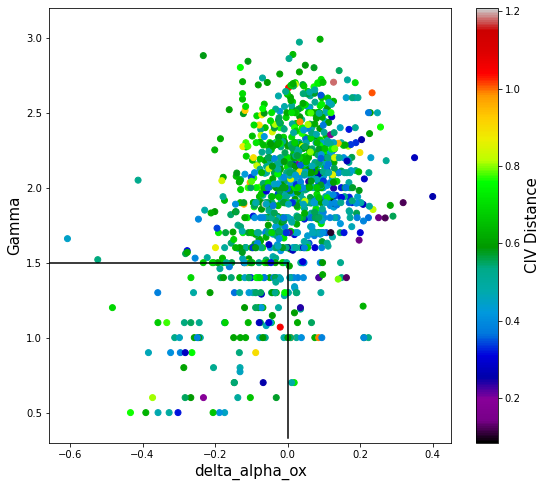

In [9]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(0.3,3.2)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

In [10]:
np.median(CIVdist)

0.5439466432796531

We don't know the absorption track for each individual object.  Instead, we'll compute a "central" value of CIV Distance in bins of $\Gamma$ by taking the mean of a Gaussian fit to the sigma-clipped distribution of CIV distances in each Gamma bin.  

In [11]:
#Create bins in gamma that will have equal number of objects in each
gamma_bins = [0.5] #start here
Nbin = 0 #increment

for Gamma in np.sort(gamma):
    Nbin += 1
    if Nbin%80==0:
        gamma_bins.append(Gamma)
gamma_bins.append(Gamma)
gamma_bins = np.array(gamma_bins)
gamma_bins[-1] = 3.1

In [12]:
gamma_bins

array([0.5       , 1.20000005, 1.5       , 1.62435997, 1.75999999,
       1.84694004, 1.89999998, 2.        , 2.06999993, 2.14130998,
       2.20130992, 2.29999995, 2.47712994, 2.68512988, 3.1       ])

In [13]:
#%%capture

daox_bins_list = []
daox_mean_civdist = []

n_daox_bin = 10
TOL = 0.05

for i in range(len(gamma_bins)-1):
    #mask objects in current Gamma bin
    binmask = ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1]))
    print("Gamma bin %d has %d sources in it" % ((i+1), ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1])).sum()))
    
    #Sigma-clip the distribution in this bin before fitting
    CIVdist_clipped = sigma_clip(CIVdist[binmask], sigma_lower=3, sigma_upper=3, maxiters=10, masked=False)
    clip_mask = (CIVdist[binmask]>=min(CIVdist_clipped))&(CIVdist[binmask]<=max(CIVdist_clipped))
    (mu, sigma) = norm.fit(CIVdist_clipped)
    #print(mu)
    #Mask points in this bin that are within some tolerance of the mean
    mean_mask = (abs(CIVdist[binmask][clip_mask]-mu)<TOL)
    frac_mean = []
    
    daox_bins_min, daox_bins_max = np.sort(daox[binmask][clip_mask])[2], np.sort(daox[binmask][clip_mask])[-3]
    #Create bins in gamma that will have equal number of objects in each
    daox_bins = [daox_bins_min] 
    Nbin = 0 #increment

    for del_aox in np.sort(daox[binmask][clip_mask]):
        Nbin += 1
        if Nbin%n_daox_bin==0:
            daox_bins.append(del_aox)
    #daox_bins.append(del_aox) #end here
    daox_bins = np.array(daox_bins)
    daox_bins_list.append(daox_bins)
    
    
    daox_bins_center = np.zeros(len(daox_bins)-1)
    for i in range(len(daox_bins)-1): daox_bins_center[i] = (daox_bins[i]+daox_bins[i+1])/2.    

    for i in range(len(daox_bins)-1):
        #mask objects in current Gamma bin
        daoxmask = ((daox[binmask][clip_mask]>=daox_bins[i])&(daox[binmask][clip_mask]<daox_bins[i+1]))
        Nmean = (mean_mask&daoxmask).sum()
        Ntot  = daoxmask.sum()
        frac_mean.append(Nmean/Ntot)
        #frac_mean.append(Nmean/np.sqrt(Ntot))
        #print(Nmean,Ntot)
        #frac_mean.append(Nmean)
    
    #Save ∆alpha_ox of point with CIV distance closest to mu
    #Where does the mean lie in Gamma vs. daox?
    ind_mean = np.argmax(frac_mean)
    daox_mean_civdist.append( daox_bins_center[ind_mean] )
daox_bins_list = np.array(daox_bins_list, dtype=object)

Gamma bin 1 has 84 sources in it
Gamma bin 2 has 102 sources in it
Gamma bin 3 has 93 sources in it
Gamma bin 4 has 82 sources in it
Gamma bin 5 has 81 sources in it
Gamma bin 6 has 83 sources in it
Gamma bin 7 has 147 sources in it
Gamma bin 8 has 100 sources in it
Gamma bin 9 has 82 sources in it
Gamma bin 10 has 81 sources in it
Gamma bin 11 has 86 sources in it
Gamma bin 12 has 92 sources in it
Gamma bin 13 has 81 sources in it
Gamma bin 14 has 27 sources in it


In [14]:
daox_bins_list[0]

array([-0.39093618, -0.32259674, -0.26676529, -0.18794528, -0.13117662,
       -0.07825897, -0.04678194,  0.01889967,  0.21091555])

In [15]:
daox_bins_list.shape

(14,)

In [16]:
gamma_bins_plot = np.zeros(len(gamma_bins)-1)

for i in range(len(gamma_bins)-1):
    gamma_bins_plot[i] = (gamma_bins[i]+gamma_bins[i+1])/2.

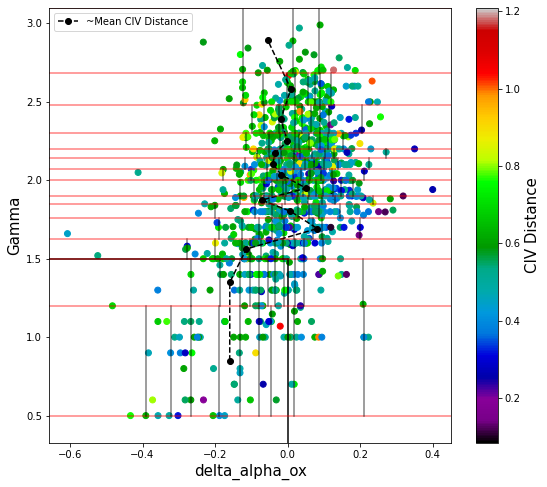

In [17]:
m_mean, b_mean = np.polyfit(gamma_bins_plot, daox_mean_civdist, 1)
x_mean_range = gamma_bins_plot.copy()
y_mean = m_mean*x_mean_range + b_mean
fit_meanciv = np.array([y_mean, x_mean_range]).T

fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(daox_mean_civdist, gamma_bins_plot, "--o", color="k", label="~Mean CIV Distance")
#plt.plot(fit_meanciv[:,0], fit_meanciv[:,1], "-o", color="k") #, label="~Mean CIV Distance")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)

#Draw bin boundaries
for i in range(len(gamma_bins)): 
    plt.plot(xlims, [gamma_bins[i], gamma_bins[i]], "-r", alpha=0.5)
    if not i==len(gamma_bins)-1:
        for j in range(len(daox_bins_list[i])):
            plt.plot([daox_bins_list[i][j],daox_bins_list[i][j]], [gamma_bins[i], gamma_bins[i+1]], "-k", alpha=0.5)
    

plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

In [18]:
def avg_line(line):
    x = line[:,0]
    y = line[:,1]
    line_new = np.zeros((line.shape[0]-1,2))
    for i in range(len(line_new)): line_new[i,:] = (x[i]+x[i+1])/2., (y[i]+y[i+1])/2.
    return line_new

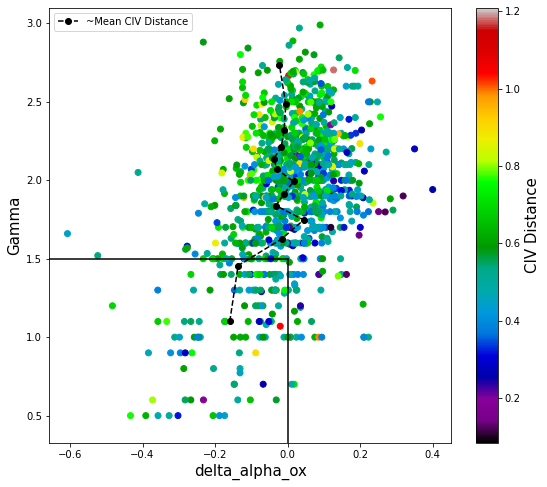

In [19]:
track_civ_avg = avg_line(np.array([daox_mean_civdist, gamma_bins_plot]).T)

fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(track_civ_avg[:,0], track_civ_avg[:,1], "--o", color="k", label="~Mean CIV Distance")
#plt.plot(fit_meanciv[:,0], fit_meanciv[:,1], "-o", color="k", label="~Mean CIV Distance, fitted")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

The problem with just taking the point where the median CIV distance is that it may happen to be an outlier in $\Delta\alpha_\mathrm{ox}$ and hence not really track where the "center" of CIV distance is in each Gamma bin.

Instead, in the above I take the mean $\Delta\alpha_\mathrm{ox}$ of the ``2*TOL`` CIV distances closest to the median, which roughly tracks where the "central" CIV distance is in each Gamma bin.

Now, change each $\Delta\alpha_\mathrm{ox}$ in each Gamma bin so that the medians of the bins align at ~0.

Want to loop through each data point

1) Check which gamma it's closest to in the plot; save index

2) Save $\Delta\alpha_{ox}$ corresponding to the given gamma (based on the median)

3) Shift $\Delta\alpha_{ox}$ for that object by minus that much

In [20]:
daox_ref = daox_mean_civdist[np.abs(daox_mean_civdist).argmin()]

daox_new = []
for i in range(len(gamma)):
    ind = abs(gamma[i]-track_civ_avg[:,1]).argmin()
    gamma_close = track_civ_avg[ind,1]
    daox_close = track_civ_avg[ind,0]
    daox_new.append(daox[i]-daox_close+daox_ref)
daox_new = np.array(daox_new)

In [21]:
%%capture
#Recompute median daox
mean_daox_new = []
for i in range(len(gamma_bins)-1):
    #mask objects in current Gamma bin
    binmask = ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1]))
    
    #Sigma-clip the distribution in this bin before fitting
    CIVdist_clipped = sigma_clip(CIVdist[binmask], sigma_lower=3, sigma_upper=3, maxiters=10, masked=False)
    clip_mask = (CIVdist[binmask]>=min(CIVdist_clipped))&(CIVdist[binmask]<=max(CIVdist_clipped))
    (mu, sigma) = norm.fit(CIVdist_clipped)
    
    #Mask points in this bin that are within some tolerance of the mean
    mean_mask = (abs(CIVdist[binmask]-mu)<TOL)
    frac_mean = []
    
    daox_bins_min, daox_bins_max = np.sort(daox_new[binmask])[2], np.sort(daox_new[binmask])[-3]

    #Create bins in gamma that will have equal number of objects in each
    daox_bins = [] #start here
    Nbin = 0 #increment

    for del_aox in np.sort(daox_new[binmask]):
        Nbin += 1
        if Nbin%n_daox_bin==0:
            daox_bins.append(del_aox)
    #daox_bins.append(daox_bins_max) #end here
    daox_bins = np.array(daox_bins)
    #daox_bins_list.append(daox_bins)
    
    
    daox_bins_center = np.zeros(len(daox_bins)-1)
    for i in range(len(daox_bins)-1): daox_bins_center[i] = (daox_bins[i]+daox_bins[i+1])/2.   

    for i in range(len(daox_bins)-1):
        #mask objects in current Gamma bin
        daoxmask = ((daox_new[binmask]>=daox_bins[i])&(daox_new[binmask]<=daox_bins[i+1]))
        Nmean = (mean_mask&daoxmask).sum()
        Ntot  = daoxmask.sum()
        frac_mean.append(Nmean/Ntot)
        #frac_mean.append(Nmean/np.sqrt(Ntot))
    
    #Save ∆alpha_ox of point with CIV distance closest to mu
    #Where does the mean lie in Gamma vs. daox?
    ind_mean = np.argmax(frac_mean)
    mean_daox_new.append( daox_bins_center[ind_mean] )

In [22]:
mean_daox_new

[-0.0005054813574363742,
 0.14130015270233487,
 0.054539564993055505,
 -0.12798811225891585,
 0.06319959568711697,
 0.08850920673133478,
 0.04500351480989427,
 -0.02706344899410811,
 -0.004802179099941517,
 -0.0020381428569609117,
 0.00964062146430306,
 -0.036990023966253616,
 -0.023037253263715037,
 0.07306163189406117]

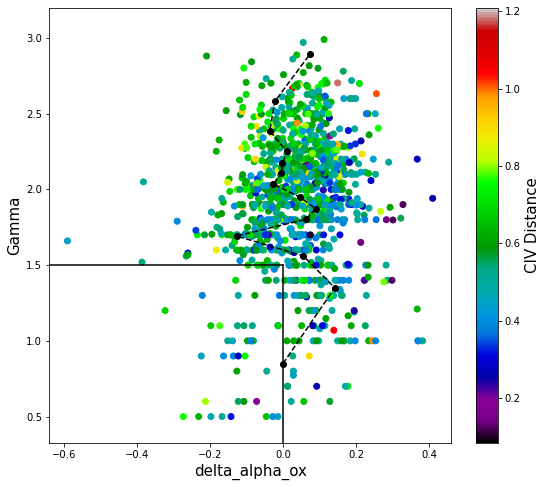

In [23]:
#m,b = np.polyfit(median_daox_new[2:], gamma_bins_plot[2:], 1)
#x = np.linspace(-0.6, 0.45, 10000)
#y = m*x + b

fig = plt.figure(figsize=(9,8))
plt.scatter(daox_new, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(mean_daox_new, gamma_bins_plot, "--o", color="k")
#plt.plot(mode_daox_new, gamma_bins_plot, "--o", color="k")
#plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.2)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

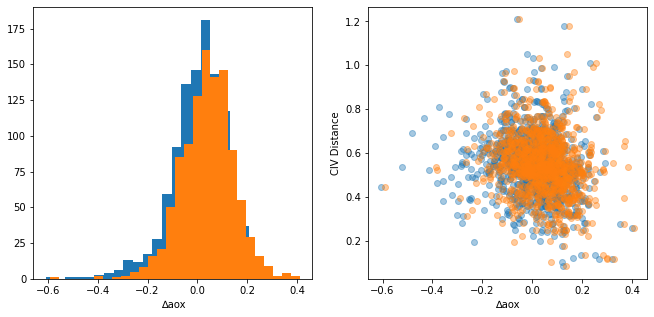

In [24]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))

ax1.hist(daox, bins="scott", label="Original ∆aox")
ax1.hist(daox_new, bins="scott", label="Median-gamma shifted ∆aox")
ax1.set_xlabel("∆aox")

ax2.scatter(daox, CIVdist, alpha=0.4, label="Original ∆aox")
ax2.scatter(daox_new, CIVdist, alpha=0.4, label="Median-gamma shifted ∆aox")
ax2.set_xlabel("∆aox")
ax2.set_ylabel("CIV Distance")

plt.show()

Now look at the new distribution.  Is it OK to shift $\alpha_\mathrm{ox}$ like this?

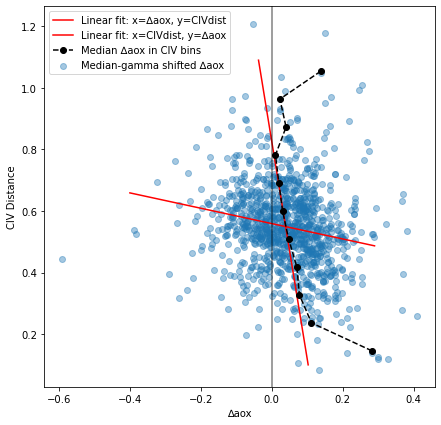

In [25]:
#See what a simple linear fit looks like - do two versions, flipping the axes
m1,b1 = np.polyfit(daox_new, CIVdist, 1)
x1 = np.arange(-0.4, 0.3, 0.01)
y1 = m1*x1 + b1
fit_lin1 = np.array([x1,y1]).T

m2,b2 = np.polyfit(CIVdist, daox_new, 1)
x2 = np.arange(0.1, 1.1, 0.01)
y2 = m2*x2 + b2
fit_lin2 = np.array([y2,x2]).T

#Also get the median ∆aox in each CIV bin
CIVdist_bins  = np.linspace(0.1, 1.1, 12)
median_daox_new_civ = []
for i in range(len(CIVdist_bins)-1):
    daox_new_med = np.median(daox_new[((CIVdist>=CIVdist_bins[i])&(CIVdist<CIVdist_bins[i+1]))])
    median_daox_new_civ.append(daox_new_med)
CIVdist_bins_plot = CIVdist_bins[:-1] + ((CIVdist_bins[1]-CIVdist_bins[0])/2)



fig, ax1 = plt.subplots(figsize=(7,7))

ax1.scatter(daox_new, CIVdist, alpha=0.4, label="Median-gamma shifted ∆aox")
#plot_contour(daox_new, CIVdist, c="b", label="Median-gamma shifted ∆aox")
ax1.plot(fit_lin1[:,0], fit_lin1[:,1], "-r", label="Linear fit: x=∆aox, y=CIVdist")
ax1.plot(fit_lin2[:,0], fit_lin2[:,1], "-r", label="Linear fit: x=CIVdist, y=∆aox")
ax1.plot(median_daox_new_civ, CIVdist_bins_plot, "--o", c="k", label="Median ∆aox in CIV bins")

xlims, ylims = ax1.get_xlim(), ax1.get_ylim()
ax1.plot([0.0,0.0], [0.0,1.4], "-k", alpha=0.5)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)

ax1.set_xlabel("∆aox")
ax1.set_ylabel("CIV Distance")
ax1.legend(loc="best")

plt.show()

Check new $\alpha_\mathrm{ox}$ vs. L2500

$$ \alpha_{ox,fit} = \alpha_{ox} - \Delta\alpha_{ox} $$

So the new $\alpha_{ox}$ value is 

$$ \alpha_{ox,new} = \alpha_{ox,old} - (\Delta\alpha_{ox,old} - \Delta\alpha_{ox,new}) $$

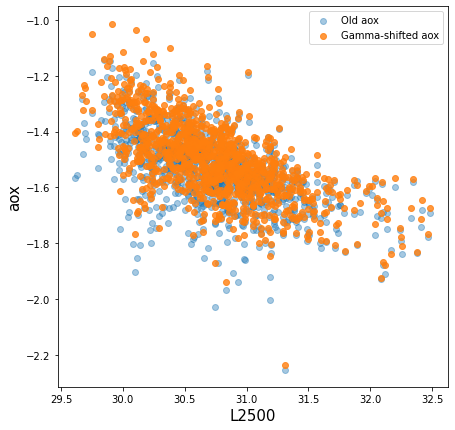

In [26]:
aox           = dat["Alpha_ox"].values #original aox values
aox_gamma     = aox - (daox - daox_new) #aox shifted based on gamma bins
L2500 = dat["L2500"].values

fig = plt.figure(figsize=(7,7))
plt.scatter(L2500, aox, alpha=0.4, label="Old aox")
plt.scatter(L2500, aox_gamma, alpha=0.8, label="Gamma-shifted aox")
plt.ylabel("aox", fontsize=15)
plt.xlabel("L2500", fontsize=15)
plt.legend(loc="best")
plt.show()

---

Now want to shift individual points in each gamma bin based on their CIV distance.

Fit a line to the newly shifted Gamma vs. daox data

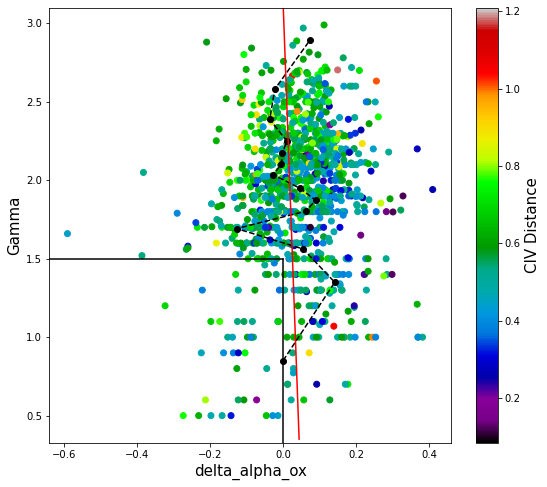

In [27]:
m_gamma, b_gamma = np.polyfit(gamma_bins_plot, mean_daox_new, 1)
x_gamma = np.linspace(0.35,4.05,1000)
y_gamma = m_gamma*x_gamma + b_gamma
fit_gamma = np.array([y_gamma,x_gamma]).T

fig = plt.figure(figsize=(9,8))
plt.scatter(daox_new, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(mean_daox_new, gamma_bins_plot, "--o", color="k")
plt.plot(fit_gamma[:,0], fit_gamma[:,1], "-r")
#plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

In [28]:
m_gamma

-0.01578479821595141

We now need a fit of CIV distance vs distance from the red line above.  Then, based on each object's CIV distance, we'll shift it a given amount towards the red line.


1) Scale the data (so as to shift orthogonally towards the red line)

Looping through each data point above:

2) Get the distance from the red line


In [29]:
def lin_slope(line):
    #return slope of a linear fit
    return (line[1,1]-line[0,1])/(line[1,0]-line[0,0])

def line_intersection(line1, line2):
    #Get the x-y intersection of two line segments
    
    #Only care about the endpoints
    line1 = ( (line1[0,0], line1[0,1]), (line1[-1,0], line1[-1,1]) )
    line2 = ( (line2[0,0], line2[0,1]), (line2[-1,0], line2[-1,1]) )
    
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


def project_pt(pt, fit):
    #Get distance^2 of point from line - minimum
    r2 = (pt[1]-fit[:,1])**2 + (pt[0]-fit[:,0])**2
    return np.array((fit[r2.argmin(),0], fit[r2.argmin(),1]))


def perp_distance(data, xax, yax):
    #Find the distance (with magnitude) of each point from the line
        
    disty = []
    distx = []
    abs_disty = []
    abs_distx = []
    int_x, int_y = line_intersection(xax, yax) #intersection of the two new axes (the "origin")
    
    for i in range(len(data)):
        r_y = np.sqrt( (data[i,0] - yax[:,0])**2 + (data[i,1] - yax[:,1])**2 )
        r_x = np.sqrt( (data[i,0] - xax[:,0])**2 + (data[i,1] - xax[:,1])**2 )
        ind_yax = r_y.argmin()
        ind_xax = r_x.argmin()
        abs_disty.append(min(r_y)) ; abs_distx.append(min(r_x))
        
        #Get which side the of the line the point is on so we can have negative distances
        proj_x = project_pt(data[i,:], xax)
        side_y = 1 if (proj_x[0]>=int_x) else -1
        disty.append(side_y*min(r_y))
        
    return np.array(disty)

In [30]:
def argmedian1(data):
    return np.argsort(data)[len(data)//2]

In [31]:
yax = fit_gamma.copy()
indmed = argmedian1(yax[:,1]) #get index where gamma is median - just for visual purposes
data_gamma = np.array([daox_new, gamma]).T

#Create and fit the scaler
scaler_gamma = MinMaxScaler().fit(data_gamma[data_gamma[:,1]<3.1]) #Max out scaler at 3.1
data_gamma_scale = scaler_gamma.transform(data_gamma)
yax_scale = scaler_gamma.transform(yax)

#Create a perpendicular axis in the scaled space
x_perp_scale = np.linspace(-.05, 1.05, 500)
m_gamma_perp_scale = -1 / lin_slope(yax_scale)
xi, yi = yax_scale[indmed,:]
b_gamma_perp_scale = yi - m_gamma_perp_scale*xi
xax_scale = np.array( [ x_perp_scale, m_gamma_perp_scale*x_perp_scale + b_gamma_perp_scale ] ).T

In [32]:
yax_scale[indmed,:]

array([0.60506602, 0.68347464])

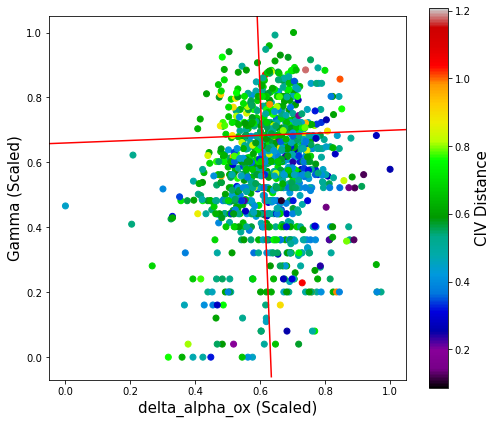

In [33]:
fig = plt.figure(figsize=(8,7))
plt.scatter(data_gamma_scale[:,0], data_gamma_scale[:,1], c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
#plt.plot([xlims[0],0],[1.5,1.5], "-k")
#plt.plot([0,0],[ylims[0],1.5], "-k")
#plt.plot(median_daox_new, gamma_bins_plot, "--o", color="k")
plt.plot(yax_scale[:,0], yax_scale[:,1], "-r")
plt.plot(xax_scale[:,0], xax_scale[:,1], "-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],1.05)
plt.xlim(xlims)
plt.ylabel("Gamma (Scaled)", fontsize=15)
plt.xlabel("delta_alpha_ox (Scaled)", fontsize=15)
plt.gca().set_aspect("equal")
plt.show()

Now that we have new x- and y-axes, we can determine distances from the scaled y-axis.  Note that the x-axis is just to determine which side of the y-axis each point is on.

The distance is:

$$ r_i = \min{ \sqrt{ ({\bf x_\mathrm{line}} - x_i)^2 + ({\bf y_\mathrm{line}} - y_i)^2 } } $$

By using the new x-axis as well, we can also project the point onto it -- then, if its x-value on the new x-axis is higher than the x-value of the point where the lines intersect, it is positive distance from the line.  Negative distance in the opposite scenario.

Get the distances from the new y-axis and plot against CIV distance; it looks like there should be a correlation.

In [34]:
dist_yax_scaled = perp_distance(data_gamma_scale, xax_scale, yax_scale)

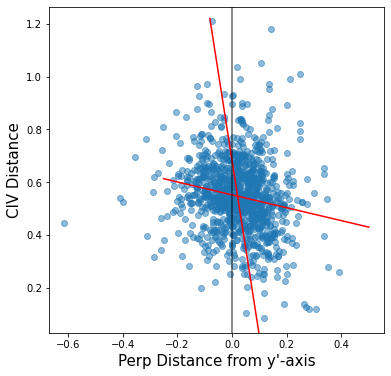

In [35]:
m_civ,b_civ = np.polyfit(CIVdist[CIVdist<1], dist_yax_scaled[CIVdist<1], 1)
yrange_civ = np.linspace(0.02,1.22,500)
x_civ = m_civ*yrange_civ + b_civ

m_civ2,b_civ2 = np.polyfit(dist_yax_scaled[CIVdist<1], CIVdist[CIVdist<1], 1)
xrange_civ2 = np.linspace(-.25,.5,500)
y_civ2 = m_civ2*xrange_civ2 + b_civ2


fig = plt.figure(figsize=(6,6))
plt.scatter(dist_yax_scaled, CIVdist, alpha=0.5)
#plot_contour(dist_yax_scaled, CIVdist, c="b")
ylims = plt.gca().get_ylim()
plt.plot(x_civ, yrange_civ, "-r")
plt.plot(xrange_civ2, y_civ2, "-r")
plt.plot([0,0],[-0.1,1.5],"-k", alpha=0.6)
plt.ylabel("CIV Distance", fontsize=15)
plt.xlabel("Perp Distance from y'-axis", fontsize=15)
plt.ylim(ylims)
plt.show()

In [36]:
m_civ,b_civ

(-0.15041008408356255, 0.1023918618731193)

Get a fit that evenly bisects the two above. The angle two slopes make is given by:

$$ \phi = \tan^{-1}(\frac{m_1-m_2}{1+m_1m_2}). $$

So the slope between the two is:

$$ \tilde{m} = \frac{m_1 - \tan(\phi/2)}{1+m_1\tan(\phi/2)} $$

In [37]:
#Scale above data
perp_civ_data = np.array([dist_yax_scaled, CIVdist]).T
fit_ydaox = np.array([x_civ, yrange_civ]).T
fit_yCIV = np.array([xrange_civ2, y_civ2]).T

scaler_civ = MinMaxScaler().fit(perp_civ_data)
perp_civ_data_scaled = scaler_civ.transform(perp_civ_data)
fit_ydaox_scale = scaler_civ.transform(fit_ydaox)
fit_yCIV_scale = scaler_civ.transform(fit_yCIV)

In [38]:
#Get point of intersection for two lines above
intfit_x_scaled, intfit_y_scaled = line_intersection(fit_yCIV_scale, fit_ydaox_scale)

#Get the slope splitting the angle between slopes in half
m1_scale = lin_slope(fit_yCIV_scale)
m2_scale = lin_slope(fit_ydaox_scale)

phi = np.arctan((m1_scale-m2_scale)/(1+m1_scale*m2_scale))
m_new_scaled = (m1_scale-np.tan(phi/2)) / (1+m1_scale*np.tan(phi/2))
b_new_scaled = intfit_y_scaled - intfit_x_scaled*m_new_scaled
x_new_scaled = np.linspace(0.50, 0.78, 1000)
y_new_scaled = m_new_scaled*x_new_scaled + b_new_scaled
fit_new_scaled = np.array([x_new_scaled, y_new_scaled]).T

#reverse back into normal coordinates
fit_new = scaler_civ.inverse_transform(fit_new_scaled)

In [39]:
intfit_x_scaled, intfit_y_scaled

(0.6309973753684001, 0.41082305022339777)

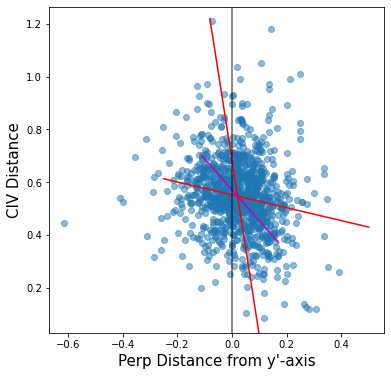

In [40]:
fig = plt.figure(figsize=(6,6))
plt.scatter(dist_yax_scaled, CIVdist, alpha=0.5)
#l = plot_contour(dist_yax_scaled, CIVdist, c="b")
ylims = plt.gca().get_ylim()
plt.plot(x_civ, yrange_civ, "-r")
plt.plot(xrange_civ2, y_civ2, "-r")
plt.plot(fit_new[:,0], fit_new[:,1], "-m")
plt.plot([0,0],[-0.1,1.5],"-k", alpha=0.6)
plt.ylabel("CIV Distance", fontsize=15)
plt.xlabel("Perp Distance from y'-axis", fontsize=15)
plt.ylim(ylims)
plt.show()

Now, given a point's CIV distance, what do we expect the perpendicular distance from the y'-axis to be?  This is the distance towards zero we'll shift that point.

And the unit vector pointing along the orthogonal projection of the the point onto the curve gives the direction to shift:

$$ \hat{\bf r}_i = \frac{( x_\mathrm{line,min} - x_i, y_\mathrm{line,min} - y_i )}{r_i} $$

If the original position of the data is ${\bf x}$, then its position along the new y axis ${\bf x}'$ is given by:

$$ {\bf x}' = {\bf x} + r_i\hat{\bf r}_i $$

In this, we'll fit for $r_i$ as a function of CIV distance.

In [41]:
def diag_shift(data, line, mag_shift):
    data_proj = project_pt(data, line)
    rvec = np.array((data_proj[0]-data[0], data_proj[1]-data[1]))
    rmag = np.linalg.norm(rvec)
    rhat = rvec / rmag
    return data + mag_shift*rhat

In [51]:
data_gamma_civ_scale = []
for i in range(len(CIVdist)):
    #Get index of the fitted CIV distance of point
    indperp = abs(CIVdist[i]-fit_new[:,1]).argmin()
    perpshift = fit_new[indperp,0]
    data_shifted = diag_shift(data_gamma_scale[i,:], yax_scale, abs(perpshift))
    data_gamma_civ_scale.append(data_shifted)
data_gamma_civ_scale = np.array(data_gamma_civ_scale)

In [52]:
#Now inverse transform back into unscaled Gamma vs. ∆aox space
data_gamma_civ = scaler_gamma.inverse_transform(data_gamma_civ_scale)

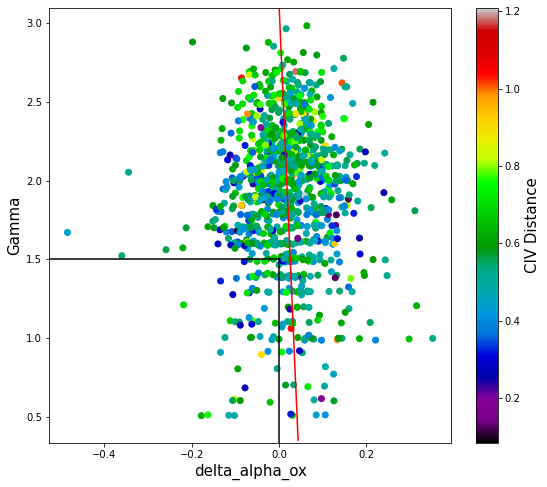

In [53]:
fig = plt.figure(figsize=(9,8))
plt.scatter(data_gamma_civ[:,0], data_gamma_civ[:,1], c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(fit_gamma[:,0], fit_gamma[:,1], "-r")
#plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

The color gradient is not as strong anymore, so it looks like it worked.  Now check again the spread in $\Delta\alpha_\mathrm{ox}$ and L2500 vs. $\alpha_\mathrm{ox}$ to see if spread decreased

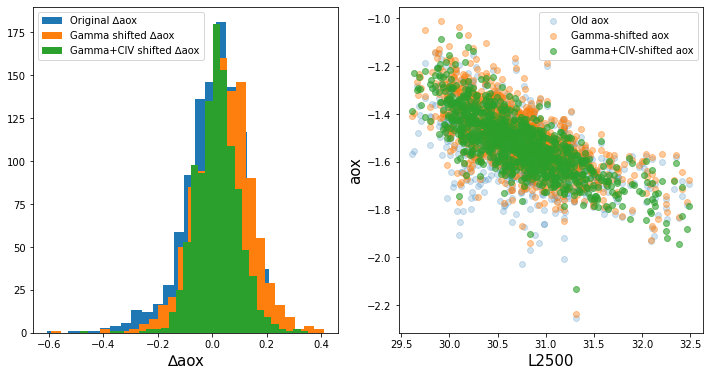

In [54]:
aox_gamma_civ = aox - (daox - data_gamma_civ[:,0]) #aox shifted based on gamma bins

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(daox, bins="scott", label="Original ∆aox")
ax1.hist(daox_new, bins="scott", label="Gamma shifted ∆aox")
ax1.hist(data_gamma_civ[:,0], bins="scott", label="Gamma+CIV shifted ∆aox")
ax1.set_xlabel("∆aox", fontsize=15)
ax1.legend(loc="best")

ax2.scatter(L2500, aox, alpha=0.2, label="Old aox")
ax2.scatter(L2500, aox_gamma, alpha=0.4, label="Gamma-shifted aox")
ax2.scatter(L2500, aox_gamma_civ, alpha=0.6, label="Gamma+CIV-shifted aox")
ax2.set_ylabel("aox", fontsize=15)
ax2.set_xlabel("L2500", fontsize=15)
ax2.legend(loc="best")

plt.show()

Seems to have worked -- but are we still using $\Delta\alpha_\mathrm{ox}$ too much?

----

In [55]:
import emcee
from scipy.optimize import minimize

def log_likelihood(theta, x, y, xerr, yerr):
    m, b, log_disp = theta
    model = m*x + b
    sigma2 = xerr**2 + yerr**2 + np.exp(2*log_disp)
    return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )

def log_prior(theta):
    m, b, log_disp = theta
    if -6 < m < 1 and -10. < b < 10. and np.log10(0.0001) < log_disp < np.log10(0.5):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

def mcmc_fit(x, y, xerr, yerr):
    #to plot on the flux grid
    x0 = np.linspace(x.min(), x.max(), 10)
    
    #First just find ML fit for MCMC initialization
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([0.9, -0.4, np.log(0.4)]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, xerr, yerr))
    m_ml, b_ml, log_disp_ml = soln.x
    
    #Initalize and run MCMC
    pos = soln.x + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, xerr, yerr))
    sampler.run_mcmc(pos, 5000, progress=True)
    
    #Remove the "burn-in" period
    tau = sampler.get_autocorr_time()
    flat_samples = sampler.get_chain(discard=int(2*np.mean(tau)), thin=15, flat=True)
        
    #Return gamma+uncertainties, dispersion
    return np.percentile(flat_samples[:, 0], [16, 50, 84]), np.exp(np.percentile(flat_samples[:, 2], [50]))

In [56]:
aox_params = mcmc_fit(L2500, aox, np.zeros(len(aox)), np.zeros(len(aox)))
aox_gamma_params = mcmc_fit(L2500, aox_gamma, np.zeros(len(aox_gamma)), np.zeros(len(aox_gamma)))
aox_gamma_civ_params = mcmc_fit(L2500, aox_gamma_civ, np.zeros(len(aox_gamma_civ)), np.zeros(len(aox_gamma_civ)))
#aox_gamma_civ_params_clean = mcmc_fit(L2500[GOOD], aox_gamma_civ[GOOD], np.zeros(len(aox_gamma_civ[GOOD])), np.zeros(len(aox_gamma_civ[GOOD])))

100%|██████████| 5000/5000 [00:09<00:00, 549.40it/s]


In [57]:
aox_params, aox_gamma_params, aox_gamma_civ_params#, aox_gamma_civ_params_clean

((array([-0.16218842, -0.15736489, -0.1525615 ]), array([0.11138793])),
 (array([-0.1880351 , -0.18335936, -0.17862846]), array([0.10603842])),
 (array([-0.1977678 , -0.19430645, -0.19082047]), array([0.07939982])))

In [58]:
print("Parameters for fits above:\n")

print("Regular aox      : Slope = %.4f±%.4f, Dispersion = %.4f" % (aox_params[0][0], aox_params[0][1]-aox_params[0][0], aox_params[1][0]))
print("Gamma aox        : Slope = %.4f±%.4f, Dispersion = %.4f" % (aox_gamma_params[0][0], aox_gamma_params[0][1]-aox_gamma_params[0][0], aox_gamma_params[1][0]))
print("Gamma+CIVdist aox: Slope = %.4f±%.4f, Dispersion = %.4f" % (aox_gamma_civ_params[0][0], aox_gamma_civ_params[0][1]-aox_gamma_civ_params[0][0], aox_gamma_civ_params[1][0]))
#print("Clean aox: Slope = %.4f±%.4f, Dispersion = %.4f" % (aox_gamma_civ_params_clean[0][0], aox_gamma_civ_params_clean[0][1]-aox_gamma_civ_params_clean[0][0], aox_gamma_civ_params_clean[1][0]))

Parameters for fits above:

Regular aox      : Slope = -0.1622±0.0048, Dispersion = 0.1114
Gamma aox        : Slope = -0.1880±0.0047, Dispersion = 0.1060
Gamma+CIVdist aox: Slope = -0.1978±0.0035, Dispersion = 0.0794
